In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import math

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDPM
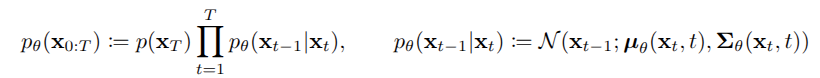
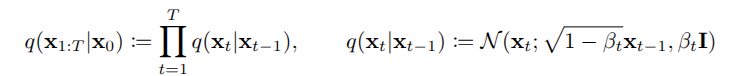
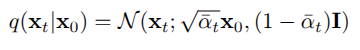
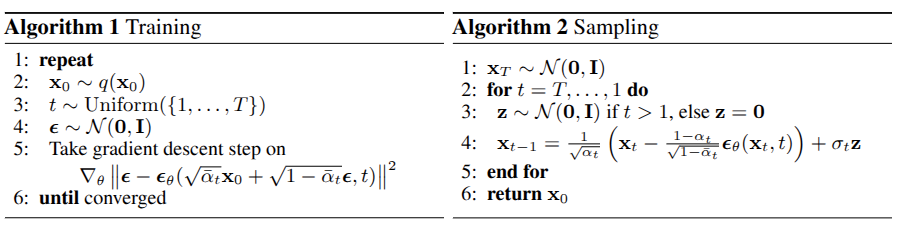

In [4]:
def gather(x: torch.Tensor, t: Union[int, torch.Tensor]):
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x.device)
    elif isinstance(t, list):
        t = torch.tensor(t, dtype=torch.long, device=x.device)
    elif isinstance(t, torch.Tensor):
        t = t.to(dtype=torch.long, device=x.device)
    else:
        raise ValueError("Unsupported type for t")

    temp = x.gather(0, t)
    return temp.reshape(-1, 1, 1, 1)


class DDPM:
    def __init__(self, model: nn.Module, device: torch.device, n_steps=1000, beta_start=1e-4, beta_end=0.02, s=0.001):
        super().__init__()
        self.n_steps = n_steps
        self.model = model
        self.device = device
        self.s = s
        
        # Compute alpha_bar using cosine schedule
        t = torch.arange(n_steps + 1, device=device)  # Include t=0 for alpha_bar_0
        alpha_bar_t = self._cosine_schedule(t / n_steps)
        
        # Compute betas from alpha_bar
        alpha_bar_prev = torch.cat([torch.tensor([1.0], device=device), alpha_bar_t[:-1]])
        betas = torch.clamp(1 - (alpha_bar_t / alpha_bar_prev), max=0.999)
        
        # Store parameters
        self.betas = betas[:n_steps]  # Exclude the extra step we added
        self.alphas = 1 - self.betas
        self.alpha_bar = alpha_bar_t[:n_steps]
    
    def _cosine_schedule(self, t):
        """Compute alpha_bar_t using cosine schedule"""
        return torch.cos((t + self.s) / (1 + self.s) * math.pi / 2) ** 2
    
    def q(self, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the forward diffusion process q(x_t | x_{t-1}).
        """
        alpha_bar_t = gather(self.alpha_bar, t)
        mean = torch.sqrt(alpha_bar_t) * x_0
        var = 1. - gather(self.alpha_bar, t)
        return mean, var
    
    def q_sample(self, x_0, t, eps=None):
        """
        Sample from the forward diffusion process q(x_t | x_0).
        """
        if eps is None:
            eps = torch.randn_like(x_0)
        mean, var = self.q(x_0, t)
        return mean + torch.sqrt(var) * eps
    
    def p_sample(self, x_t, t):
        eps_theta = self.model(x_t, t)
        alpha_bar_t = gather(self.alpha_bar, t)
        alpha_t = gather(self.alphas, t)
        mean = (1. / torch.sqrt(alpha_t)) * (x_t - (1. - alpha_t) / torch.sqrt(1. - alpha_bar_t) * eps_theta)
        var = gather(self.betas, t)
        eps = torch.randn_like(x_t, device=self.device)
        return mean + torch.sqrt(var) * eps
    
    def loss(self, x_0, noise=None):
        """
        Compute the loss for the model.
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        t = torch.randint(0, self.n_steps, (x_0.size(0),), device=self.device)
        x_t = self.q_sample(x_0, t, noise)
        eps_theta = self.model(x_t, t)
        return F.mse_loss(eps_theta, noise)
    
    def sample(self, n_samples=1, image_size=(1, 28, 28), xt=None):
        if xt is not None:
            x_t = xt.to(self.device)
        else:
            x_t = torch.randn(n_samples, *image_size).to(self.device)
        
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x_t = self.p_sample(x_t, t_batch)  # assumes p_sample does noise addition
        
        return torch.clamp(x_t, -1.0, 1.0)


# UNet
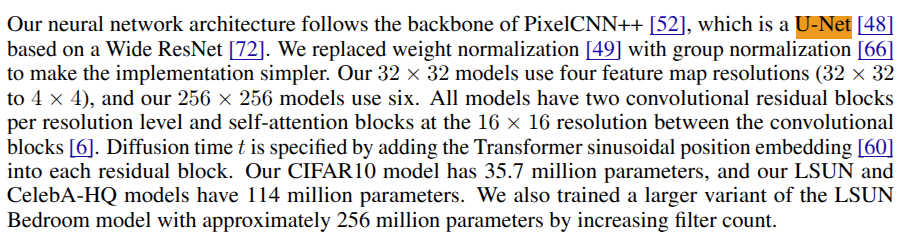
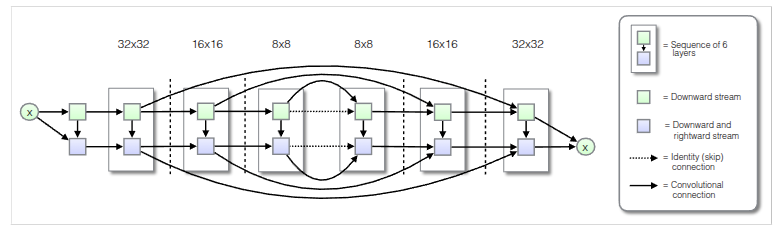

In [5]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, groups=8):
        super().__init__()
        self.group_norm1 = nn.GroupNorm(groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.group_norm2 = nn.GroupNorm(groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_emb = nn.Linear(time_dim, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.group_norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.group_norm2(h)
        h += self.time_emb(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)

class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1).permute(0, 2, 1)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)
        
        attn = torch.bmm(q, k) * (C ** -0.5)
        attn = F.softmax(attn, dim=-1)
        
        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return x + self.proj_out(out)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim)
        )

        # Downsampling
        self.down1 = nn.ModuleList([
            ResidualBlock(in_channels, base_channels, time_dim, groups=1),
            ResidualBlock(base_channels, base_channels, time_dim)
        ])
        self.down2 = nn.ModuleList([
            ResidualBlock(base_channels, base_channels*2, time_dim),
            SelfAttentionBlock(base_channels*2),
            ResidualBlock(base_channels*2, base_channels*2, time_dim)
        ])
        
        # Middle
        self.mid = nn.ModuleList([
            ResidualBlock(base_channels*2, base_channels*4, time_dim),
            SelfAttentionBlock(base_channels*4),
            ResidualBlock(base_channels*4, base_channels*2, time_dim)
        ])
        
        # Upsampling
        self.up2 = nn.ModuleList([
            ResidualBlock(base_channels*4, base_channels*2, time_dim),
            SelfAttentionBlock(base_channels*2),
            ResidualBlock(base_channels*2, base_channels, time_dim)
        ])
        self.up1 = nn.ModuleList([
            ResidualBlock(base_channels*2, base_channels, time_dim),
            ResidualBlock(base_channels, base_channels, time_dim)
        ])
        
        self.final_conv = nn.Conv2d(base_channels, out_channels, 3, padding=1)
        
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t):
        t = self.time_mlp(t)
        x1 = []
        
        # Downsample path
        # Block 1 (28x28 -> 28x28)
        for block in self.down1:
            x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 14x14
        
        # Block 2 (14x14 -> 14x14)
        for block in self.down2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 7x7
        
        # Middle (7x7 -> 7x7)
        for block in self.mid:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        
        # Upsample path
        # Block 2 (7x7 -> 14x14)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        
        # Block 1 (14x14 -> 28x28)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up1:
            x = block(x, t)
        
        return self.final_conv(x)



# model = UNet()
# x = torch.randn(8, 1, 28, 28)  # MNIST batch
# t = torch.randint(0, 1000, (8,))  # Random timesteps
# output = model(x, t)
# print(output.shape)  # Should be (8, 1, 28, 28)


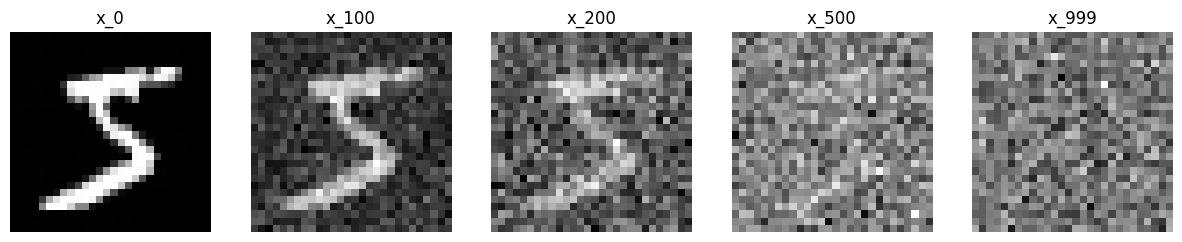

In [6]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("samples", exist_ok=True)

config = {
    'batch_size': 1280,
    'epochs': 100,
    'lr': 1e-4,
    'n_steps': 1000,
    'weight_decay': 1e-5,
    'max_grad_norm': 1.0,
    'save_interval': 50,
    
}

# Data augmentation
transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Initialization
model = UNet().to(device)
diffusion = DDPM(model, device, n_steps=config['n_steps'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
sampled_image = dataloader.dataset.data[:1].unsqueeze(1).float() / 255.0

timesteps = [0, 100, 200, 500, 999]
sampled_images = []

for t in timesteps:
    sampled_image = diffusion.q_sample(sampled_image.unsqueeze(0).to(device), t=torch.tensor([t]).to(device))
    sampled_images.append(sampled_image.squeeze().cpu())

# Plot the sampled images
plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip(timesteps, sampled_images)):
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"x_{t}")
    plt.axis('off')
plt.show()

Epoch 1/100:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 47/47 [00:06<00:00,  7.57it/s, Loss=0.1706]


Epoch 1 | Avg Loss: 0.4193


Epoch 2/100: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.1233]


Epoch 2 | Avg Loss: 0.1481


Epoch 3/100: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.1004]


Epoch 3 | Avg Loss: 0.1132


Epoch 4/100: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0941]


Epoch 4 | Avg Loss: 0.0962


Epoch 5/100: 100%|██████████| 47/47 [00:06<00:00,  7.71it/s, Loss=0.0852]


Epoch 5 | Avg Loss: 0.0874


Epoch 6/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0877]


Epoch 6 | Avg Loss: 0.0827


Epoch 7/100: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0727]


Epoch 7 | Avg Loss: 0.0768


Epoch 8/100: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=0.0758]


Epoch 8 | Avg Loss: 0.0747


Epoch 9/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0665]


Epoch 9 | Avg Loss: 0.0722


Epoch 10/100: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0700]


Epoch 10 | Avg Loss: 0.0699


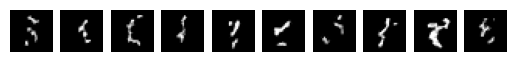

Epoch 11/100: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0741]


Epoch 11 | Avg Loss: 0.0705


Epoch 12/100: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0667]


Epoch 12 | Avg Loss: 0.0684


Epoch 13/100: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0675]


Epoch 13 | Avg Loss: 0.0668


Epoch 14/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0661]


Epoch 14 | Avg Loss: 0.0649


Epoch 15/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0643]


Epoch 15 | Avg Loss: 0.0640


Epoch 16/100: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0616]


Epoch 16 | Avg Loss: 0.0620


Epoch 17/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0607]


Epoch 17 | Avg Loss: 0.0621


Epoch 18/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0597]


Epoch 18 | Avg Loss: 0.0614


Epoch 19/100: 100%|██████████| 47/47 [00:05<00:00,  7.83it/s, Loss=0.0636]


Epoch 19 | Avg Loss: 0.0601


Epoch 20/100: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0580]


Epoch 20 | Avg Loss: 0.0593


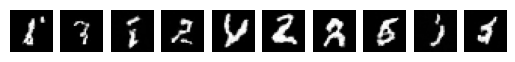

Epoch 21/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0595]


Epoch 21 | Avg Loss: 0.0609


Epoch 22/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0571]


Epoch 22 | Avg Loss: 0.0596


Epoch 23/100: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0589]


Epoch 23 | Avg Loss: 0.0592


Epoch 24/100: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=0.0619]


Epoch 24 | Avg Loss: 0.0587


Epoch 25/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0578]


Epoch 25 | Avg Loss: 0.0574


Epoch 26/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0550]


Epoch 26 | Avg Loss: 0.0567


Epoch 27/100: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=0.0570]


Epoch 27 | Avg Loss: 0.0565


Epoch 28/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0565]


Epoch 28 | Avg Loss: 0.0561


Epoch 29/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0518]


Epoch 29 | Avg Loss: 0.0560


Epoch 30/100: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0528]


Epoch 30 | Avg Loss: 0.0559


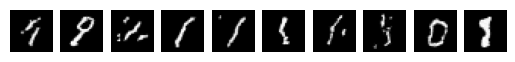

Epoch 31/100: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0611]


Epoch 31 | Avg Loss: 0.0565


Epoch 32/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0542]


Epoch 32 | Avg Loss: 0.0552


Epoch 33/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0537]


Epoch 33 | Avg Loss: 0.0540


Epoch 34/100: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=0.0535]


Epoch 34 | Avg Loss: 0.0538


Epoch 35/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0512]


Epoch 35 | Avg Loss: 0.0540


Epoch 36/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0522]


Epoch 36 | Avg Loss: 0.0542


Epoch 37/100: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0527]


Epoch 37 | Avg Loss: 0.0538


Epoch 38/100: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0539]


Epoch 38 | Avg Loss: 0.0539


Epoch 39/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0532]


Epoch 39 | Avg Loss: 0.0531


Epoch 40/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0528]


Epoch 40 | Avg Loss: 0.0525


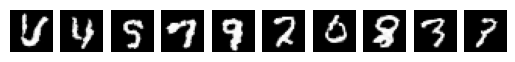

Epoch 41/100: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0549]


Epoch 41 | Avg Loss: 0.0528


Epoch 42/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0514]


Epoch 42 | Avg Loss: 0.0532


Epoch 43/100: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0496]


Epoch 43 | Avg Loss: 0.0520


Epoch 44/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0548]


Epoch 44 | Avg Loss: 0.0527


Epoch 45/100: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0539]


Epoch 45 | Avg Loss: 0.0531


Epoch 46/100: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0514]


Epoch 46 | Avg Loss: 0.0528


Epoch 47/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0512]


Epoch 47 | Avg Loss: 0.0526


Epoch 48/100: 100%|██████████| 47/47 [00:05<00:00,  7.83it/s, Loss=0.0525]


Epoch 48 | Avg Loss: 0.0520


Epoch 49/100: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0501]


Epoch 49 | Avg Loss: 0.0517


Epoch 50/100: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0532]


Epoch 50 | Avg Loss: 0.0514


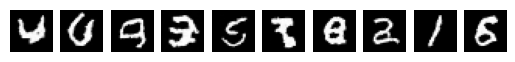

Epoch 51/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0484]


Epoch 51 | Avg Loss: 0.0510


Epoch 52/100: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0484]


Epoch 52 | Avg Loss: 0.0510


Epoch 53/100: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0547]


Epoch 53 | Avg Loss: 0.0513


Epoch 54/100: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0492]


Epoch 54 | Avg Loss: 0.0506


Epoch 55/100: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0516]


Epoch 55 | Avg Loss: 0.0503


Epoch 56/100: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0497]


Epoch 56 | Avg Loss: 0.0505


Epoch 57/100: 100%|██████████| 47/47 [00:05<00:00,  7.83it/s, Loss=0.0523]


Epoch 57 | Avg Loss: 0.0504


Epoch 58/100: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0519]


Epoch 58 | Avg Loss: 0.0501


Epoch 59/100: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0528]


Epoch 59 | Avg Loss: 0.0501


Epoch 60/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0513]


Epoch 60 | Avg Loss: 0.0500


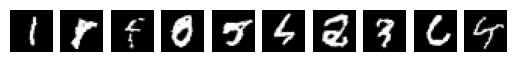

Epoch 61/100: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0491]


Epoch 61 | Avg Loss: 0.0501


Epoch 62/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0508]


Epoch 62 | Avg Loss: 0.0497


Epoch 63/100: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0522]


Epoch 63 | Avg Loss: 0.0511


Epoch 64/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0505]


Epoch 64 | Avg Loss: 0.0510


Epoch 65/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0509]


Epoch 65 | Avg Loss: 0.0502


Epoch 66/100: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0507]


Epoch 66 | Avg Loss: 0.0497


Epoch 67/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0489]


Epoch 67 | Avg Loss: 0.0493


Epoch 68/100: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0489]


Epoch 68 | Avg Loss: 0.0494


Epoch 69/100: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0469]


Epoch 69 | Avg Loss: 0.0489


Epoch 70/100: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0481]


Epoch 70 | Avg Loss: 0.0490


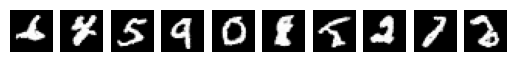

Epoch 71/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0460]


Epoch 71 | Avg Loss: 0.0487


Epoch 72/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0479]


Epoch 72 | Avg Loss: 0.0489


Epoch 73/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0505]


Epoch 73 | Avg Loss: 0.0485


Epoch 74/100: 100%|██████████| 47/47 [00:06<00:00,  7.72it/s, Loss=0.0489]


Epoch 74 | Avg Loss: 0.0486


Epoch 75/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0450]


Epoch 75 | Avg Loss: 0.0487


Epoch 76/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0482]


Epoch 76 | Avg Loss: 0.0484


Epoch 77/100: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=0.0463]


Epoch 77 | Avg Loss: 0.0497


Epoch 78/100: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0473]


Epoch 78 | Avg Loss: 0.0483


Epoch 79/100: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0498]


Epoch 79 | Avg Loss: 0.0484


Epoch 80/100: 100%|██████████| 47/47 [00:06<00:00,  7.72it/s, Loss=0.0467]


Epoch 80 | Avg Loss: 0.0481


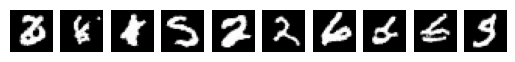

Epoch 81/100: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0458]


Epoch 81 | Avg Loss: 0.0480


Epoch 82/100: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0478]


Epoch 82 | Avg Loss: 0.0483


Epoch 83/100: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0482]


Epoch 83 | Avg Loss: 0.0481


Epoch 84/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0476]


Epoch 84 | Avg Loss: 0.0480


Epoch 85/100: 100%|██████████| 47/47 [00:06<00:00,  7.73it/s, Loss=0.0487]


Epoch 85 | Avg Loss: 0.0485


Epoch 86/100: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0486]


Epoch 86 | Avg Loss: 0.0480


Epoch 87/100: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0484]


Epoch 87 | Avg Loss: 0.0482


Epoch 88/100: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0478]


Epoch 88 | Avg Loss: 0.0482


Epoch 89/100: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0462]


Epoch 89 | Avg Loss: 0.0477


Epoch 90/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0462]


Epoch 90 | Avg Loss: 0.0474


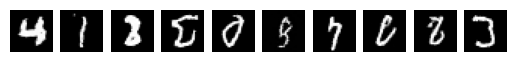

Epoch 91/100: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=0.0480]


Epoch 91 | Avg Loss: 0.0473


Epoch 92/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0435]


Epoch 92 | Avg Loss: 0.0476


Epoch 93/100: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0475]


Epoch 93 | Avg Loss: 0.0472


Epoch 94/100: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=0.0458]


Epoch 94 | Avg Loss: 0.0470


Epoch 95/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0475]


Epoch 95 | Avg Loss: 0.0473


Epoch 96/100: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0470]


Epoch 96 | Avg Loss: 0.0483


Epoch 97/100: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0450]


Epoch 97 | Avg Loss: 0.0469


Epoch 98/100: 100%|██████████| 47/47 [00:06<00:00,  7.74it/s, Loss=0.0470]


Epoch 98 | Avg Loss: 0.0474


Epoch 99/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0462]


Epoch 99 | Avg Loss: 0.0469


Epoch 100/100: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0456]


Epoch 100 | Avg Loss: 0.0470


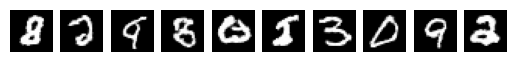

Training completed!


In [7]:
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
best_loss = float('inf')
sample = True
for epoch in range(config['epochs']):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    total_loss = 0
    
    for images, _ in pbar:
        images = images.to(device)
        
        # Training step
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm']) # prevent gradient exploding
        optimizer.step()
        
        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
    

    #scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    if sample and (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(1, 28, 28))
            for i, img in enumerate(sampled_images):
                plt.subplot(1, 10, i + 1)
                plt.imshow(img.squeeze().cpu(), cmap='gray')
                plt.axis('off')
            plt.show()

    if (epoch + 1) % config['save_interval'] == 0:
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': avg_loss,
        }, f"checkpoints/checkpoint_{epoch+1:03d}.pth")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")
